In [72]:
#Import all the required libraries


!pip install wordcloud
!pip install gTTs
!pip install playsound

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import glob
import random as rn
import os
from PIL import Image
rn.seed(42)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(42)
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
#from keras.optimizers import Adam, RMSprop
from collections import Counter
import string
import json
from tqdm import tqdm
import time
from keras.models import Model
from tensorflow.keras import Input, layers
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add

from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Conv2D

from skimage import io
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth',-1)

from tensorflow.keras.optimizers import Adam, RMSprop

from gtts import gTTS
from playsound import playsound
from IPython import display

  Using cached wordcloud-1.9.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (520 kB)
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
  Using cached gTTS-2.5.0-py3-none-any.whl (29 kB)
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
  Using cached playsound-1.3.0-py3-none-any.whl
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [3]:
#Importing the dataset and reading the image into a seperate variable

image_folder ='../datasets/flickr/Images/'

all_imgs = glob.glob(image_folder + '*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


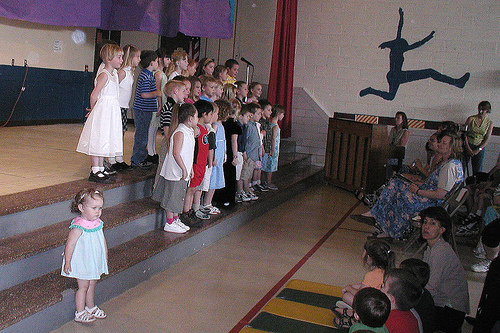

In [4]:
#Visualise both the images & text present in the dataset

Image.open(all_imgs[0])

In [5]:
all_imgs[0]


'../datasets/flickr/Images/2046778775_0dd7cac6ab.jpg'

In [6]:


#Import the dataset and read the text file into a separate variable

def load_doc(filename):

    text=open(filename).read()

    return text

def get_img_ids_and_captions(text):
    keys=[]
    values=[]
    key_paths=[]
    text=text.splitlines()[1:]
    for line in text:
        com_idx=line.index(",")
        im_id,im_cap=line[:com_idx],line[com_idx+1:]
        keys.append(im_id)
        values.append(im_cap)
        key_paths.append(image_folder+'/'+im_id)
    return keys,values,key_paths

text_file="datasets/flickr/captions.txt"

doc = load_doc(text_file)
print(doc[:500], "........")

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3 ........


### Create a dataframe which summarizes the image, path & captions as a dataframe

---



Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [7]:
all_img_id,annotations,all_img_vector= get_img_ids_and_captions(doc)#store all the image id here


df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])

df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,../datasets/flickr/Images//1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,../datasets/flickr/Images//1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,../datasets/flickr/Images//1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,../datasets/flickr/Images//1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,../datasets/flickr/Images//1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
...,...,...,...
40450,997722733_0cb5439472.jpg,../datasets/flickr/Images//997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,../datasets/flickr/Images//997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,../datasets/flickr/Images//997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock face covered in assist handles .
40453,997722733_0cb5439472.jpg,../datasets/flickr/Images//997722733_0cb5439472.jpg,A rock climber in a red shirt .


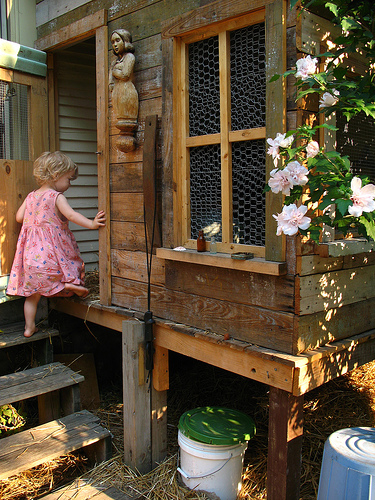

In [8]:
Image.open(all_img_vector[0])


A man wearing a black sweatshirt poses for a picture in a parking lot .


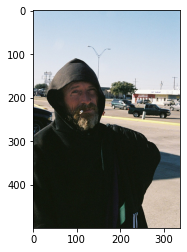

In [9]:
# Reading a random image from dataframe
row = rn.randint(0,df.shape[0])
image = plt.imread(df.loc[row,'Path'])
plt.imshow(image)

print(df.loc[row,'Captions'])

In [10]:

#Create the vocabulary & the counter for the captions
def voc_fetcher(frame,column):
    out=[]
    for i in frame[column]:
        out+=i.split(" ")
    return out


vocabulary=voc_fetcher(df,"Captions")
val_count=Counter(vocabulary)
val_count

Counter({'A': 21481,
         'child': 1477,
         'in': 18961,
         'a': 40271,
         'pink': 734,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1944,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3217,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7982,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 771,
         'on': 10729,
         'road': 388,
         'white': 3875,
         'brown': 2475,
         'spots': 29,
         'staring'

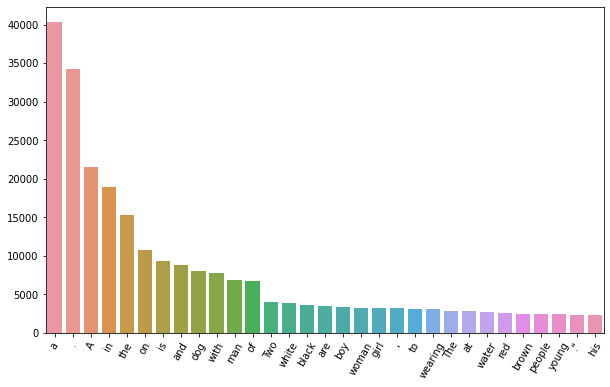

In [11]:

#Visualise the top 30 occuring words in the captions
def get_top_words_based_on_cnt(words_dict,n_words):
    n_words+=1
    keys=list(words_dict.keys())
    values=list(words_dict.values())
    sorted_values=sorted(values,reverse=True)[:n_words]
    sorted_keys=[]
    for i in sorted_values:
        if sorted_values.count(i)==1:
            sorted_keys.append(keys[values.index(i)])
        elif sorted_values.count(i)==2:
            f_idx=values.index(i)
            s_idx=values[f_idx+1:].index(i)
            s_idx+=f_idx+1
            a,b=keys[f_idx],keys[s_idx]
            if a not in sorted_keys and b not in sorted_keys:
                sorted_keys.append(a)
                sorted_keys.append(b)
    plt.figure(figsize=(10,6))
    sns.barplot(x=sorted_keys,y=sorted_values)
    plt.xticks(rotation=60)
    plt.show()
    #write your code here
get_top_words_based_on_cnt(val_count,30)


### Create a list which contains all the captions & path

In [12]:
#Create a list which contains all the captions
annotations=df.Captions.apply(lambda z:"<start>"+" "+z+" "+"<end>")

#add the <start> & <end> token to all those captions as well


#Create a list which contains all the path to the images
all_img_path=df.Path.to_list()#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [13]:
annotations

0        <start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>   
1        <start> A girl going into a wooden building . <end>                                      
2        <start> A little girl climbing into a wooden playhouse . <end>                           
3        <start> A little girl climbing the stairs to her playhouse . <end>                       
4        <start> A little girl in a pink dress going into a wooden cabin . <end>                  
                                          ...                                                     
40450    <start> A man in a pink shirt climbs a rock face <end>                                   
40451    <start> A man is rock climbing high in the air . <end>                                   
40452    <start> A person in a red shirt climbing up a rock face covered in assist handles . <end>
40453    <start> A rock climber in a red shirt . <end>                                            
40454    <

### Pre-Processing the captions

1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [14]:
# create the tokenizer
top_word_cnt = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_cnt,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)
train_sequence = tokenizer.texts_to_sequences(annotations)

In [15]:
train_sequence[:10]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4],
 [3, 2, 16, 10, 9, 2, 844, 10, 18, 344, 4],
 [3, 2, 16, 10, 9, 2, 1576, 236, 10, 35, 11, 138, 83, 7, 6, 152, 4],
 [3, 2, 16, 10, 9, 2, 15, 10, 11, 28, 1002, 18, 641, 23, 138, 83, 5, 6, 73, 4],
 [3, 14, 32, 13, 742, 2654, 90, 23, 138, 83, 7, 6, 152, 4],
 [3, 14, 32, 7, 728, 806, 322, 138, 83, 4]]

In [16]:
# Create word-to-index and index-to-word mappings.
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_sequence = tokenizer.texts_to_sequences(annotations)

In [17]:
tokenizer.word_counts


OrderedDict([('<start>', 40455),
             ('a', 62992),
             ('child', 1545),
             ('in', 18986),
             ('pink', 739),
             ('dress', 348),
             ('is', 9345),
             ('climbing', 507),
             ('up', 1302),
             ('set', 109),
             ('of', 6723),
             ('stairs', 109),
             ('an', 2432),
             ('entry', 1),
             ('way', 53),
             ('<end>', 40455),
             ('girl', 3328),
             ('going', 149),
             ('into', 1074),
             ('wooden', 284),
             ('building', 510),
             ('little', 1768),
             ('playhouse', 6),
             ('the', 18419),
             ('to', 3176),
             ('her', 1178),
             ('cabin', 4),
             ('black', 3848),
             ('dog', 8138),
             ('and', 8862),
             ('spotted', 38),
             ('are', 3504),
             ('fighting', 133),
             ('tri', 14),
             ('color

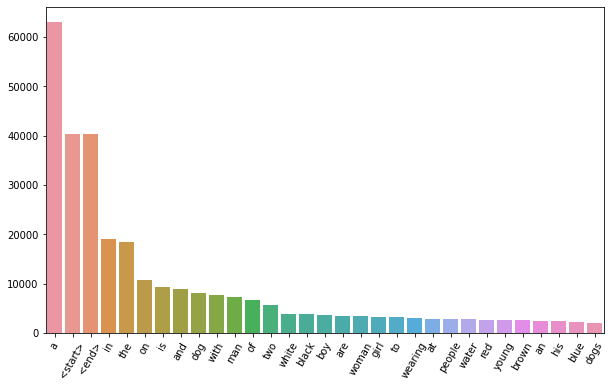

In [18]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
get_top_words_based_on_cnt(tokenizer.word_counts,30)

In [19]:
def min_max_for_nested_array(nested_array):
    array=[len(e) for e in nested_array]
    return min(array),max(array)
min_l,max_l=min_max_for_nested_array(train_sequence)

In [20]:
# Pad each vector to the max_length of the captions and store it to a vairable

cap_vector=tf.keras.preprocessing.sequence.pad_sequences(train_sequence,padding='post',maxlen=max_l)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


Pre-processing the images
Resize them into the shape of (299, 299)

Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

In [21]:
#write your code here
def load_the_image(file_path):
    my_img = tf.io.read_file(file_path)
    my_img = tf.image.decode_jpeg(my_img, channels=3)
    my_img = tf.image.resize(my_img, (299, 299))
    my_img = tf.keras.applications.inception_v3.preprocess_input(my_img)
    return my_img,file_path

2024-01-01 11:26:30.143311: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-01 11:26:30.143370: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


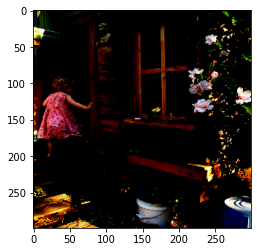

In [22]:
plt.imshow(load_the_image(all_img_vector[0])[0])

plt.show()

In [23]:
cap_vector=tf.keras.preprocessing.sequence.pad_sequences(train_sequence,padding='post',maxlen=max_l)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


In [24]:
encode_train_set = sorted(set(all_img_vector))

feature_dict = {}

image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_data_set = image_data_set.map(load_the_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

image_data_set


<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

### Create the train & test data
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)

In [25]:
image_train, image_test, caption_train, caption_test = train_test_split(all_img_vector,
                                                                        cap_vector,
                                                                        test_size=0.2,
                                                                        random_state=33)

In [26]:
print("Training data for images: " + str(len(image_train)))
print("Testing data for images: " + str(len(image_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [27]:
def map_function(image_name,capt):
    image_tensor = feature_dict[image_name.decode('utf-8')]
    return image_tensor,capt

### Load the Pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048.

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)

In [28]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = keras.Model(new_input, hidden_layer)

In [29]:
# write your code to extract features from each image in the dataset
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [30]:
# Running feature extraction
for image,path in tqdm(image_data_set):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|██████████| 253/253 [00:34<00:00,  7.42it/s]


In [31]:
batch_f.shape


TensorShape([64, 2048])

In [32]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
def generate_dataset(images_data, captions_data):

    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [33]:
train_dataset=generate_dataset(image_train,caption_train)
test_dataset=generate_dataset(image_test,caption_test)

In [34]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(32, 64, 2048)
(32, 39)


### Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [35]:
embedd_dim = 256
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(image_train) // BATCH_SIZE
test_num_steps = len(image_test) // BATCH_SIZE

## Encoder

In [36]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.fc = layers.Dense(embed_dim)
        self.dropout = layers.Dropout(0.5)

    def call(self, features):
        features = self.fc(features)
        features = tf.nn.relu(features)
        return features

In [37]:
encoder=Encoder(embedd_dim)


### Attention model

In [38]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights =  keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)


        return context_vector, attention_weights

In [39]:
class RNN_Decoder(Model):
    def __init__(self, embedd_dim, units, vocab_size):

        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = layers.Embedding(vocab_size, embedd_dim)
        self.gru = layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

        self.fc1 = layers.Dense(self.units)
        self.fc2 = layers.Dense(vocab_size)

        self.attention = Attention_model(self.units)

    def call(self, x, features, hidden):
    # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
        output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

## Decoder

In [40]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #Initializing Attention model with units
        self.embed = layers.Embedding(vocab_size, embed_dim,mask_zero=False) # Building an Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units)
        self.d2 = layers.Dense(vocab_size)
        self.dropout = Dropout(0.5)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed = self.dropout(self.embed(x))
        mask = self.embed.compute_mask(x)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        output,state = self.gru(embed,mask=mask)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2]))
        output = self.d2(output)

        return output,state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [41]:
decoder=Decoder(embedd_dim, units, vocab_size)


In [42]:
# Encoder and decoder output shapes check

features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape))
print('Predcitions shape from Decoder: {}'.format(predictions.shape))
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape))

#sample_img_batch

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


### Model training & optimization

1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [43]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [44]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [45]:
checkpoint_path = "checkpoints"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,
                                          checkpoint_path,
                                          max_to_keep=5)

In [46]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [47]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss, avg_loss

In [48]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, avg_loss

In [49]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    return avg_test_loss

In [50]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps

    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.189, & test loss is 1.000
Time taken for 1 epoch 248.72697234153748 sec

Test loss has been reduced from 100.000 to 1.000


  7%|▋         | 1/15 [04:09<58:07, 249.10s/it]

For epoch: 2, the train loss is 0.938, & test loss is 0.889
Time taken for 1 epoch 123.50211787223816 sec

Test loss has been reduced from 1.000 to 0.889


 13%|█▎        | 2/15 [06:13<38:01, 175.47s/it]

For epoch: 3, the train loss is 0.856, & test loss is 0.822
Time taken for 1 epoch 130.65849232673645 sec

Test loss has been reduced from 0.889 to 0.822


 20%|██        | 3/15 [08:24<31:02, 155.22s/it]

For epoch: 4, the train loss is 0.797, & test loss is 0.769
Time taken for 1 epoch 133.4227192401886 sec

Test loss has been reduced from 0.822 to 0.769


 27%|██▋       | 4/15 [10:37<26:54, 146.76s/it]

For epoch: 5, the train loss is 0.748, & test loss is 0.723
Time taken for 1 epoch 123.84972643852234 sec

Test loss has been reduced from 0.769 to 0.723


 33%|███▎      | 5/15 [12:42<23:06, 138.65s/it]

For epoch: 6, the train loss is 0.706, & test loss is 0.684
Time taken for 1 epoch 121.55789637565613 sec

Test loss has been reduced from 0.723 to 0.684


 40%|████      | 6/15 [14:44<19:56, 132.99s/it]

For epoch: 7, the train loss is 0.667, & test loss is 0.647
Time taken for 1 epoch 130.35414123535156 sec

Test loss has been reduced from 0.684 to 0.647


 47%|████▋     | 7/15 [16:55<17:38, 132.29s/it]

For epoch: 8, the train loss is 0.630, & test loss is 0.612
Time taken for 1 epoch 131.04501152038574 sec

Test loss has been reduced from 0.647 to 0.612


 53%|█████▎    | 8/15 [19:06<15:24, 132.03s/it]

For epoch: 9, the train loss is 0.597, & test loss is 0.582
Time taken for 1 epoch 125.78500580787659 sec

Test loss has been reduced from 0.612 to 0.582


 60%|██████    | 9/15 [21:12<13:01, 130.22s/it]

For epoch: 10, the train loss is 0.568, & test loss is 0.554
Time taken for 1 epoch 127.04716324806213 sec

Test loss has been reduced from 0.582 to 0.554


 67%|██████▋   | 10/15 [23:20<10:46, 129.38s/it]

For epoch: 11, the train loss is 0.540, & test loss is 0.526
Time taken for 1 epoch 131.44278240203857 sec

Test loss has been reduced from 0.554 to 0.526


 73%|███████▎  | 11/15 [25:32<08:40, 130.14s/it]

For epoch: 12, the train loss is 0.515, & test loss is 0.503
Time taken for 1 epoch 130.9850628376007 sec

Test loss has been reduced from 0.526 to 0.503


 80%|████████  | 12/15 [27:43<06:31, 130.52s/it]

For epoch: 13, the train loss is 0.492, & test loss is 0.481
Time taken for 1 epoch 128.42525124549866 sec

Test loss has been reduced from 0.503 to 0.481


 87%|████████▋ | 13/15 [29:52<04:20, 130.02s/it]

For epoch: 14, the train loss is 0.472, & test loss is 0.461
Time taken for 1 epoch 132.62242007255554 sec

Test loss has been reduced from 0.481 to 0.461


 93%|█████████▎| 14/15 [32:05<02:10, 130.91s/it]

For epoch: 15, the train loss is 0.452, & test loss is 0.444
Time taken for 1 epoch 133.3982605934143 sec

Test loss has been reduced from 0.461 to 0.444


100%|██████████| 15/15 [34:19<00:00, 137.28s/it]


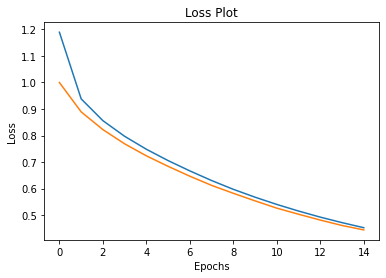

In [51]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

## Greedy Search

In [52]:

def evaluate(image):
    max_length=max_l
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_the_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [53]:
# Code visualizes attention weights for different words in a caption, overlaid on the corresponding image regions
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img=ax.imshow(temp_img)

        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [54]:
from nltk.translate.bleu_score import sentence_bleu


In [58]:
#Filters out specific words from a given text string and returns the text without those words
def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [62]:

# Extracts shape information from a feature array and stores it in variable
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

35
BELU score: 100.0
Real Caption: a person jogging on a sidewalk
Prediction Caption: a person jogging on a sidewalk


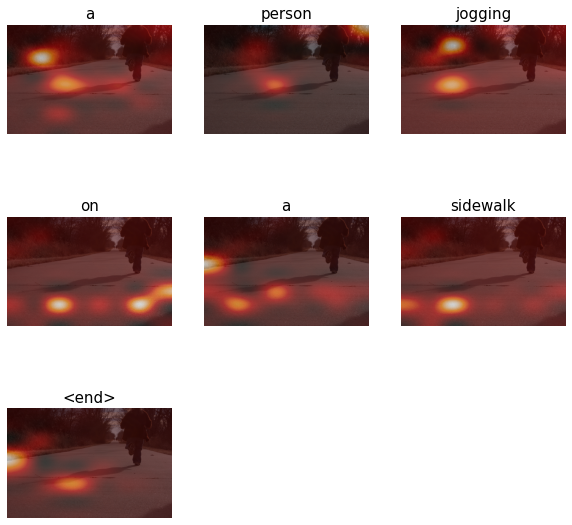

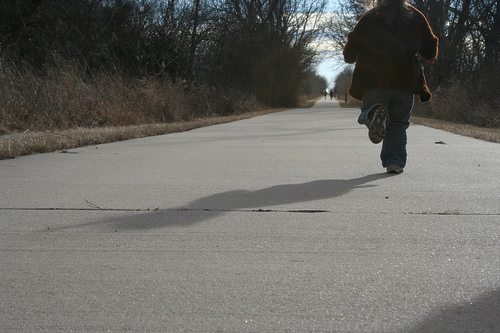

In [65]:
#modifying the given code to run it by changing weights

rid = np.random.randint(0, len(image_test))

print(rid)
test_image = image_test[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [68]:
def beam_evaluate(image, beam_index = 3):
    max_length=max_l
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_the_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)

                prob += np.log(predictions[0][w])

                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]


        predicted_id = result[-1]
        pred_list = predicted_id[0]

        prd_id = pred_list[-1]
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)
        else:
            break


    result2 = result[-1][0]

    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)

        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [69]:
captions=beam_evaluate(test_image)
print(pred_caption)

a person jogging on a sidewalk


In [74]:
   # Code generates a spoken audio version of a predicted caption and plays it:
    
    speech = gTTS("Predicted Caption is: "+ pred_caption,lang = 'en', slow = False) 
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'
    #playsound('voice.wav')
    display.display(display.Audio(audio_file, rate=None,autoplay=True))